In [1]:
!pip install numpy opencv-python pillow matplotlib

In [16]:
import numpy as np
import cv2

from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

def reverse(l):
    l.reverse()
    return l

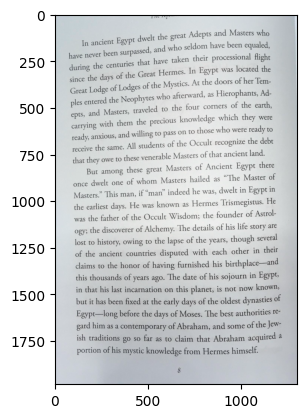

In [17]:
scanned_page = cv2.cvtColor(np.asarray(Image.open('9ube35adqzf21.jpg')), cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(scanned_page)

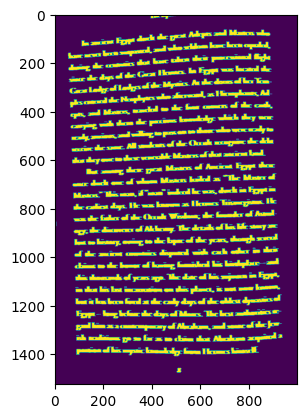

In [18]:
# Resize, binarize and apply some eroding/dilation on the original image 
height, width, nbchannels = np.shape(scanned_page)
resized_width = 1000
resized_height = round(resized_width * height / width)
resized_page = cv2.resize(scanned_page, (resized_width, resized_height))
grayscale_page = cv2.cvtColor(resized_page, cv2.COLOR_RGB2GRAY)
ADAPTIVE_WINSZ = 55
masked_page = cv2.adaptiveThreshold(
  src=grayscale_page,
  maxValue=255,
  adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
  thresholdType=cv2.THRESH_BINARY_INV,
  blockSize=ADAPTIVE_WINSZ,
  C=25,
)

def box(width, height):
    return np.ones((height, width), dtype=np.uint8)

masked_page = cv2.erode(cv2.dilate(masked_page, box(9, 1)), box(1, 3))

_ = plt.imshow(masked_page)

In [19]:
# nice color palette for visualizing contours, etc.
PALETTE = [
    (255, 0, 0),
    (255, 63, 0),
    (255, 127, 0),
    (255, 191, 0),
    (255, 255, 0),
    (191, 255, 0),
    (127, 255, 0),
    (63, 255, 0),
    (0, 255, 0),
    (0, 255, 63),
    (0, 255, 127),
    (0, 255, 191),
    (0, 255, 255),
    (0, 191, 255),
    (0, 127, 255),
    (0, 63, 255),
    (0, 0, 255),
    (63, 0, 255),
    (127, 0, 255),
    (191, 0, 255),
    (255, 0, 255),
    (255, 0, 191),
    (255, 0, 127),
    (255, 0, 63),
]


In [20]:
contours, _ = cv2.findContours(masked_page, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Create a bitmask of the contour at the size of the contour
def make_tight_mask(contour, xmin, ymin, width, height):
    tight_mask = np.zeros((height, width), dtype=np.uint8)
    # As far as I understand, we just translate the contour to 0,0 to work in the contour CS
    tight_contour = contour - np.array((xmin, ymin)).reshape((-1, 1, 2))
    cv2.drawContours(tight_mask, [tight_contour], contourIdx=0, color=1, thickness=-1)
    return tight_mask

# Uses the covariance and its eigenvector to get the direction of the blob.
# The center is obtained from those "moments"
# More details on moments: https://gregorygundersen.com/blog/2020/04/11/moments/
# OpenCV API: https://docs.opencv.org/3.4/d8/d23/classcv_1_1Moments.html
def blob_mean_and_tangent(contour) -> tuple[float, float] | None:
    """
    Construct blob image's covariance matrix from second order central moments
    (i.e. dividing them by the 0-order 'area moment' to make them translationally
    invariant), from the eigenvectors of which the blob orientation can be
    extracted (they are its principle components).
    """
    moments = cv2.moments(contour)
    area = moments["m00"]
    if area:
        mean_x = moments["m10"] / area
        mean_y = moments["m01"] / area
        covariance_matrix = np.divide(
            [[moments["mu20"], moments["mu11"]], [moments["mu11"], moments["mu02"]]],
            area,
        )
        _, svd_u, _ = cv2.SVDecomp(covariance_matrix)
        center = np.array([mean_x, mean_y])
        tangent = svd_u[:, 0].flatten().copy()
        # print(f"Got contour with {center=} {tangent=}")
        return center, tangent
    else:
        # Sometimes `cv2.moments()` returns all-zero moments. Prevent ZeroDivisionError
        print("Discarding contour with zero moments")
        return None

# Represent a contour of a text of line
class ContourInfo:
    def __init__(self, contour, moments, rect, mask):
        self.contour = contour
        self.rect = rect
        self.mask = mask
        # The tangent is the principal axis of the contour
        self.center, self.tangent = moments
        self.angle = np.arctan2(self.tangent[1], self.tangent[0])
        # cls is the array of all the projections on the tangent
        clx = [self.proj_x(point) for point in self.contour]
        # lxmin and lxmax are factors that move the center on the tangent at the
        # limit of the contour
        lxmin, lxmax = min(clx), max(clx)
        self.local_xrng = (lxmin, lxmax)
        self.point0 = self.center + self.tangent * lxmin
        self.point1 = self.center + self.tangent * lxmax
        self.pred = None
        self.succ = None

    def __repr__(self) -> str:
        return (
            f"ContourInfo: contour={self.contour}, rect={self.rect}, mask={self.mask}, "
            f"center={self.center}, tangent={self.tangent}, angle={self.angle}"
        )
    # Project a point of the contour on the tangent
    def proj_x(self, point):
        return np.dot(self.tangent, point.flatten() - self.center)

    def local_overlap(self, other):
        xmin = self.proj_x(other.point0)
        xmax = self.proj_x(other.point1)
        return interval_measure_overlap(self.local_xrng, (xmin, xmax))

# Go through all the contours, select those who looks like line of text and create a ContourInfo for each
contour_infos = []
TEXT_MIN_WIDTH = 15
TEXT_MIN_HEIGHT = 2
TEXT_MIN_ASPECT = 2
TEXT_MAX_THICKNESS = resized_height / 40
print(f'TEXT_MAX_THICKNESS = {TEXT_MAX_THICKNESS}')
count = 0
for contour in contours:
    rect = cv2.boundingRect(contour)
    xmin, ymin, width, height = rect
    if width < TEXT_MIN_ASPECT * height: count += 1
    # Filter things that do not look like text
    if (width < TEXT_MIN_WIDTH
        or height < TEXT_MIN_HEIGHT
        or width < TEXT_MIN_ASPECT * height):
        print(f'contour filtered (width < TEXT_MIN_WIDTH): {width < TEXT_MIN_WIDTH} (height < TEXT_MIN_HEIGHT): {height < TEXT_MIN_HEIGHT} (width < TEXT_MIN_ASPECT * height): {width < TEXT_MIN_ASPECT * height}')
        continue
    # Create a mask from the contour. The mask as the size of the contour (not the whole image)
    tight_mask = make_tight_mask(contour, xmin, ymin, width, height)
    if tight_mask.sum(axis=0).max() > TEXT_MAX_THICKNESS:
        print(f'contour filtered tight_mask.sum(axis=0).max() ({tight_mask.sum(axis=0).max()}) > TEXT_MAX_THICKNESS {tight_mask.sum(axis=0).max() > TEXT_MAX_THICKNESS}')
        continue
    if (moments := blob_mean_and_tangent(contour)) is None:
        print('contour filtered by moment')
        continue
    info = ContourInfo(contour=contour, moments=moments, rect=rect, mask=tight_mask)
    contour_infos.append(info)
print(f'aspect ratio filtered {count}')

TEXT_MAX_THICKNESS = 38.125
contour filtered (width < TEXT_MIN_WIDTH): False (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): True
contour filtered (width < TEXT_MIN_WIDTH): True (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): False
contour filtered (width < TEXT_MIN_WIDTH): True (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): False
contour filtered (width < TEXT_MIN_WIDTH): True (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): False
contour filtered (width < TEXT_MIN_WIDTH): True (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): False
contour filtered (width < TEXT_MIN_WIDTH): False (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): True
contour filtered (width < TEXT_MIN_WIDTH): True (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPECT * height): False
contour filtered (width < TEXT_MIN_WIDTH): True (height < TEXT_MIN_HEIGHT): False (width < TEXT_MIN_ASPE

displaying 221 contours
(1525, 1000, 3)


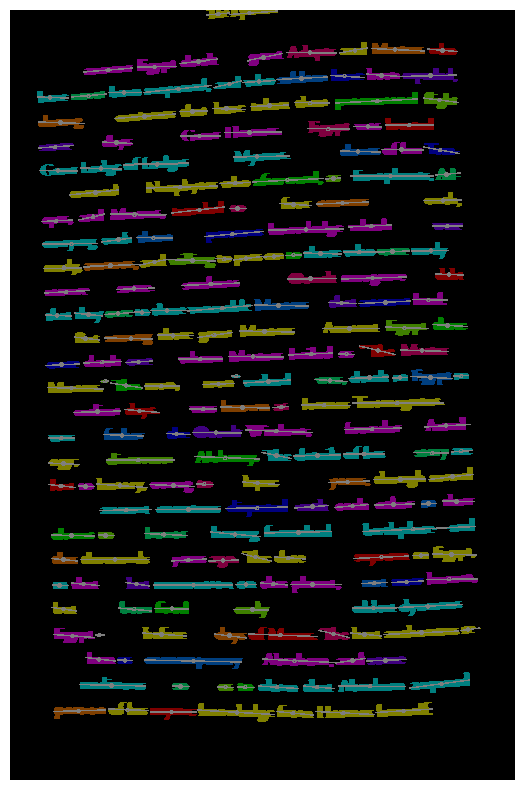

In [21]:
# Visualize the contour with their center and tangent
contour_page = np.zeros((resized_height, resized_width, 3), dtype=np.int8)
print(f'displaying {len(contour_infos)} contours')

def fltp(point):
    return tuple(point.astype(int).flatten())

for i, contour_info in enumerate(contour_infos):
    cv2.drawContours(contour_page, [contour_info.contour], 0, PALETTE[i % len(PALETTE)], -1)
    cv2.circle(contour_page, fltp(contour_info.center), 3, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.line(
        contour_page,
        fltp(contour_info.point0),
        fltp(contour_info.point1),
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )

print(np.shape(contour_page))
fig = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax = fig.add_subplot(111)
ax.axis("off")
_ = ax.imshow(contour_page, interpolation='nearest')


In [36]:
import math

# Compute a score on the probablity of two contour being part of the same line
def score_same_span(contour1, contour2):
    score = 2
    # Check there is NO overlap in X
    if (abs(contour2.rect[0] - contour1.rect[0]) > max(contour1.rect[2], contour2.rect[2])):
        score -= math.inf
    # Check there is an overlap in Y
    score -= abs(contour2.rect[1] - contour1.rect[1]) / (contour1.rect[3] * 0.7)
    # Check that the difference in angle is not too high
    score -= (abs(contour2.angle - contour1.angle) / (math.pi / 8))
    return score
# We ajust the so that the number of score above 0 is more or less the number of correct
# pairing which in our case is roughly around the number of coutours / number of lines
#print(len(contour_infos))
#print(len([float(s[2]) for s in scores if s[2] > 0]))

scores = []
# Sort by so that contour belonging to the same span should be close to each other
sorted(contour_infos, key=lambda contour: contour.rect[1])
for contour1 in contour_infos:
    for contour2 in contour_infos:
        if contour1 == contour2:
            continue
        scores.append((contour1, contour2, score_same_span(contour1, contour2)))

# Cleanup for the cell to be reentrant
for score in scores:
    if hasattr(score[0], "span"):
        delattr(score[0], 'span')
    if hasattr(score[1], "span"):
        delattr(score[1], 'span')

# spans = []
# for score in [score for score in scores if score[2] > 0]:
#     if hasattr(score[0], "span"):
#         if hasattr(score[1], "span"):
#             if score[0].span is not score[1].span:
#                 score[0].span = score[0].span + score[1].span
#                 score[1].span = score[0].span
#         else:
#             score[0].span.append(score[1])
#             score[1].span = score[0].span
#     else:
#         if hasattr(score[1], "span"):
#             score[1].span.append(score[0])
#             score[0].span = score[1].span
#         else:
#             score[0].span = []
#             score[0].span.append(score[1])
#             score[1].span = score[0].span
#             spans.append(score[0].span)


221
219
